**This notebook is an exercise in the [Intro to Deep Learning](https://www.kaggle.com/learn/intro-to-deep-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/overfitting-and-underfitting).**

---


# Introduction #

In this exercise, you’ll learn how to improve training outcomes by including an early stopping callback to prevent overfitting.

When you're ready, run this next cell to set everything up!

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.deep_learning_intro.ex4 import *

First load the *Spotify* dataset. Your task will be to predict the popularity of a song based on various audio features, like `'tempo'`, `'danceability'`, and `'mode'`.

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('../input/dl-course-data/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


Let's start with the simplest network, a linear model. This model has low capacity.

Run this next cell without any changes to train a linear model on the *Spotify* dataset.

2021-12-29 12:02:36.600672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 12:02:36.682412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 12:02:36.683159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 12:02:36.684202: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Minimum Validation Loss: 0.1936


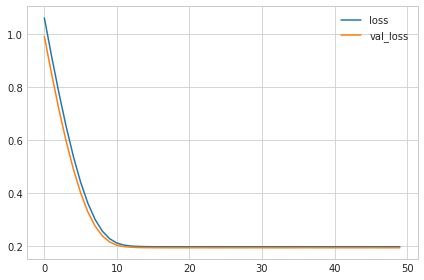

In [3]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

It's not uncommon for the curves to follow a "hockey stick" pattern like you see here. This makes the final part of training hard to see, so let's start at epoch 10 instead:

Minimum Validation Loss: 0.1936


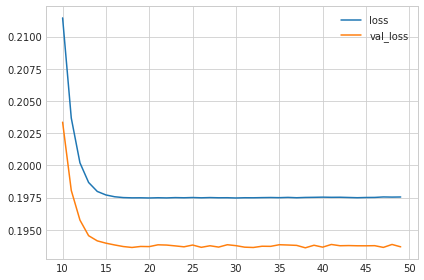

In [4]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 1) Evaluate Baseline

What do you think? Would you say this model is underfitting, overfitting, just right?

In [5]:
# View the solution (Run this cell to receive credit!)
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

The gap between these curves is quite small and the validation loss never increases, so it's more likely that the network is underfitting than overfitting. It would be worth experimenting with more capacity to see if that's the case.

Now let's add some capacity to our network. We'll add three hidden layers with 128 units each. Run the next cell to train the network and see the learning curves.

Epoch 1/50
48/48 [==============================] - 0s 4ms/step - loss: 0.2382 - val_loss: 0.2019
Epoch 2/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2015 - val_loss: 0.1970
Epoch 3/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1963 - val_loss: 0.1955
Epoch 4/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1944 - val_loss: 0.1950
Epoch 5/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1929 - val_loss: 0.1947
Epoch 6/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1911 - val_loss: 0.1944
Epoch 7/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1893 - val_loss: 0.1940
Epoch 8/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1878 - val_loss: 0.1946
Epoch 9/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1867 - val_loss: 0.1946
Epoch 10/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1859 - val_loss: 0.1948
Epoch 11/50
48/48 [

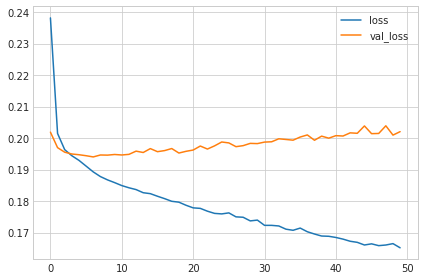

In [6]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 2) Add Capacity

What is your evaluation of these curves? Underfitting, overfitting, just right?

In [7]:
# View the solution (Run this cell to receive credit!)
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

Now the validation loss begins to rise very early, while the training loss continues to decrease. This indicates that the network has begun to overfit. At this point, we would need to try something to prevent it, either by reducing the number of units or through a method like early stopping. (We'll see another in the next lesson!)

# 3) Define Early Stopping Callback

Now define an early stopping callback that waits 5 epochs (`patience'`) for a change in validation loss of at least `0.001` (`min_delta`) and keeps the weights with the best loss (`restore_best_weights`).

In [8]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=5, 
    restore_best_weights=True
)

# Check your answer
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [ ]:
# Lines below will give you a hint or solution code
#q_3.hint()
#q_3.solution()

Now run this cell to train the model and get the learning curves. Notice the `callbacks` argument in `model.fit`.

Epoch 1/50
48/48 [==============================] - 0s 5ms/step - loss: 0.2723 - val_loss: 0.2109
Epoch 2/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2054 - val_loss: 0.2015
Epoch 3/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1996 - val_loss: 0.1984
Epoch 4/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1962 - val_loss: 0.1970
Epoch 5/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1937 - val_loss: 0.1965
Epoch 6/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1919 - val_loss: 0.1958
Epoch 7/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1905 - val_loss: 0.1954
Epoch 8/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1890 - val_loss: 0.1958
Epoch 9/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1878 - val_loss: 0.1957
Epoch 10/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1876 - val_loss: 0.1954
Epoch 11/50
48/48 [

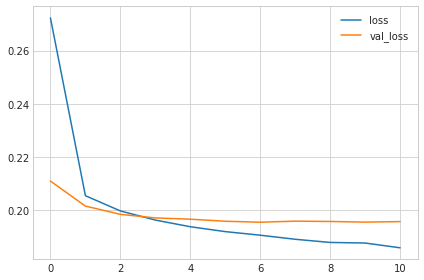

In [9]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 4) Train and Interpret

Was this an improvement compared to training without early stopping?

In [10]:
# View the solution (Run this cell to receive credit!)
q_4.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

The early stopping callback did stop the training once the network began overfitting. Moreover, by including `restore_best_weights` we still get to keep the model where validation loss was lowest.

If you like, try experimenting with `patience` and `min_delta` to see what difference it might make.

# Keep Going #

Move on to [**learn about a couple of special layers**](https://www.kaggle.com/ryanholbrook/dropout-and-batch-normalization): batch normalization and dropout.

In [12]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001, 
    patience=10, 
    restore_best_weights=True
)


Epoch 1/50
48/48 [==============================] - 0s 4ms/step - loss: 0.2684 - val_loss: 0.2096
Epoch 2/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2049 - val_loss: 0.1992
Epoch 3/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1990 - val_loss: 0.1968
Epoch 4/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1957 - val_loss: 0.1959
Epoch 5/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1931 - val_loss: 0.1950
Epoch 6/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1926 - val_loss: 0.1942
Epoch 7/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1902 - val_loss: 0.1939
Epoch 8/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1891 - val_loss: 0.1951
Epoch 9/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1878 - val_loss: 0.1945
Epoch 10/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1867 - val_loss: 0.1939
Epoch 11/50
48/48 [

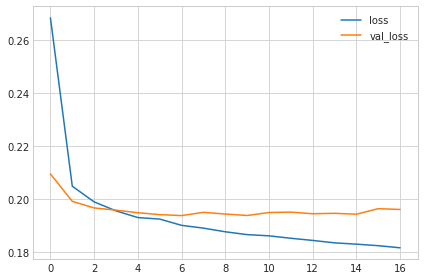

In [13]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [14]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    min_delta=0.005, 
    patience=10, 
    restore_best_weights=True
)

Epoch 1/50
48/48 [==============================] - 1s 10ms/step - loss: 0.2198 - val_loss: 0.2010
Epoch 2/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2010 - val_loss: 0.1982
Epoch 3/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1965 - val_loss: 0.1957
Epoch 4/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1932 - val_loss: 0.1961
Epoch 5/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1913 - val_loss: 0.1985
Epoch 6/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1896 - val_loss: 0.1954
Epoch 7/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1889 - val_loss: 0.1939
Epoch 8/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1869 - val_loss: 0.1958
Epoch 9/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1862 - val_loss: 0.1969
Epoch 10/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1854 - val_loss: 0.1951
Epoch 11/50
48/48 

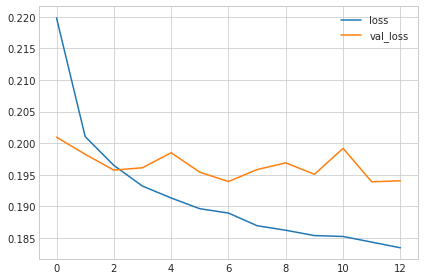

In [15]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [16]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    min_delta=0.005, 
    patience=5, 
    restore_best_weights=True
)

Epoch 1/50
48/48 [==============================] - 0s 4ms/step - loss: 0.2406 - val_loss: 0.2018
Epoch 2/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2021 - val_loss: 0.1965
Epoch 3/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1973 - val_loss: 0.1960
Epoch 4/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1940 - val_loss: 0.1943
Epoch 5/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1926 - val_loss: 0.1955
Epoch 6/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1908 - val_loss: 0.1964
Epoch 7/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1894 - val_loss: 0.1955
Minimum Validation Loss: 0.1943


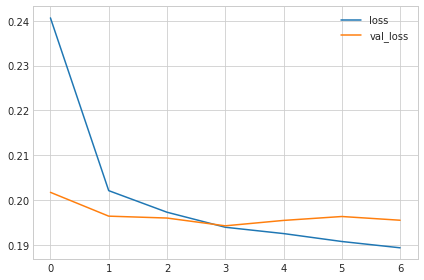

In [17]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [19]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    min_delta=0.005, 
    patience=5, 
    restore_best_weights=True
)

Epoch 1/50
95/95 [==============================] - 1s 3ms/step - loss: 0.2364 - val_loss: 0.1993
Epoch 2/50
95/95 [==============================] - 0s 3ms/step - loss: 0.1983 - val_loss: 0.1979
Epoch 3/50
95/95 [==============================] - 0s 3ms/step - loss: 0.1942 - val_loss: 0.1942
Epoch 4/50
95/95 [==============================] - 0s 2ms/step - loss: 0.1920 - val_loss: 0.1946
Epoch 5/50
95/95 [==============================] - 0s 3ms/step - loss: 0.1901 - val_loss: 0.1937
Epoch 6/50
95/95 [==============================] - 0s 3ms/step - loss: 0.1884 - val_loss: 0.1967
Epoch 7/50
95/95 [==============================] - 0s 2ms/step - loss: 0.1870 - val_loss: 0.1963
Epoch 8/50
95/95 [==============================] - 0s 2ms/step - loss: 0.1865 - val_loss: 0.1953
Minimum Validation Loss: 0.1937


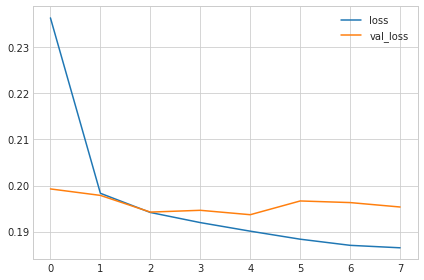

In [20]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [21]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

Epoch 1/100
189/189 [==============================] - 1s 3ms/step - loss: 0.2173 - val_loss: 0.2017
Epoch 2/100
189/189 [==============================] - 0s 2ms/step - loss: 0.1967 - val_loss: 0.1973
Epoch 3/100
189/189 [==============================] - 0s 2ms/step - loss: 0.1929 - val_loss: 0.1929
Epoch 4/100
189/189 [==============================] - 0s 2ms/step - loss: 0.1912 - val_loss: 0.1939
Epoch 5/100
189/189 [==============================] - 0s 2ms/step - loss: 0.1891 - val_loss: 0.1952
Epoch 6/100
189/189 [==============================] - 1s 3ms/step - loss: 0.1877 - val_loss: 0.1955
Minimum Validation Loss: 0.1929


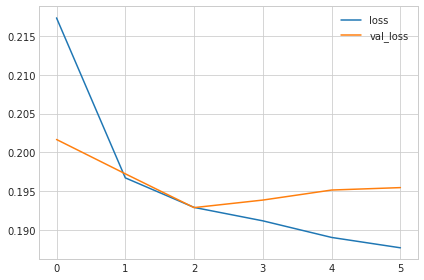

In [23]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=128,
    epochs=100,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [24]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    min_delta=0.0005, 
    patience=10, 
    restore_best_weights=True
)

Epoch 1/100
756/756 [==============================] - 3s 3ms/step - loss: 0.2067 - val_loss: 0.1971
Epoch 2/100
756/756 [==============================] - 2s 2ms/step - loss: 0.1961 - val_loss: 0.2005
Epoch 3/100
756/756 [==============================] - 2s 2ms/step - loss: 0.1930 - val_loss: 0.1940
Epoch 4/100
756/756 [==============================] - 2s 2ms/step - loss: 0.1907 - val_loss: 0.1979
Epoch 5/100
756/756 [==============================] - 2s 2ms/step - loss: 0.1895 - val_loss: 0.1925
Epoch 6/100
756/756 [==============================] - 2s 3ms/step - loss: 0.1882 - val_loss: 0.1942
Epoch 7/100
756/756 [==============================] - 2s 3ms/step - loss: 0.1872 - val_loss: 0.1983
Epoch 8/100
756/756 [==============================] - 2s 2ms/step - loss: 0.1860 - val_loss: 0.1934
Epoch 9/100
756/756 [==============================] - 2s 3ms/step - loss: 0.1845 - val_loss: 0.1932
Epoch 10/100
756/756 [==============================] - 2s 2ms/step - loss: 0.1834 - val_lo

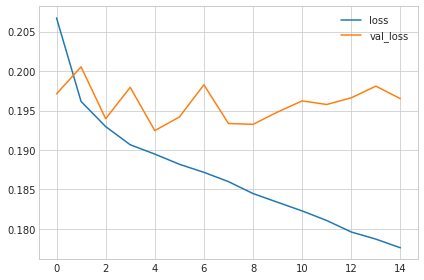

In [25]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-deep-learning/discussion) to chat with other learners.*